<a href="https://colab.research.google.com/github/sayandeepmaity/vseven_lumi/blob/main/cst_trans_gunshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Class Weights: {np.int64(0): np.float64(5.15035799522673), np.int64(1): np.float64(0.5537593020272004)}
Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8049 - loss: 0.4329 - val_accuracy: 0.9509 - val_loss: 0.1457
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9605 - loss: 0.1545 - val_accuracy: 0.9769 - val_loss: 0.0691
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9698 - loss: 0.0946 - val_accuracy: 0.9713 - val_loss: 0.0804
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9776 - loss: 0.0717 - val_accuracy: 0.9926 - val_loss: 0.0384
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9832 - loss: 0.0674 - val_accuracy: 0.9954 - val_loss: 0.0299
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9883 - loss: 0.0502 - val_accuracy: 0.9778 - val_loss: 0.0812
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9864 - loss: 0.0449 - val_accuracy: 0.9954 - val_loss: 0.0

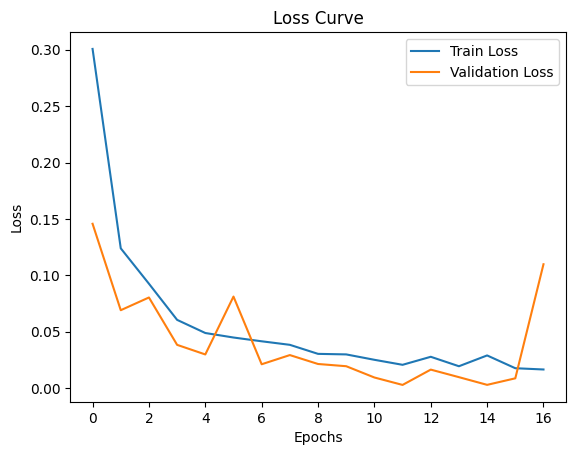

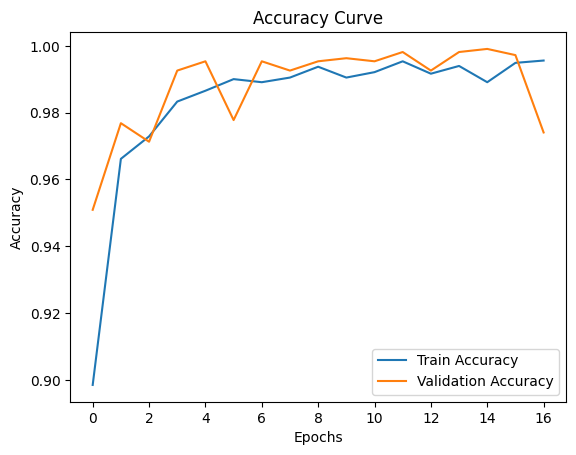

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


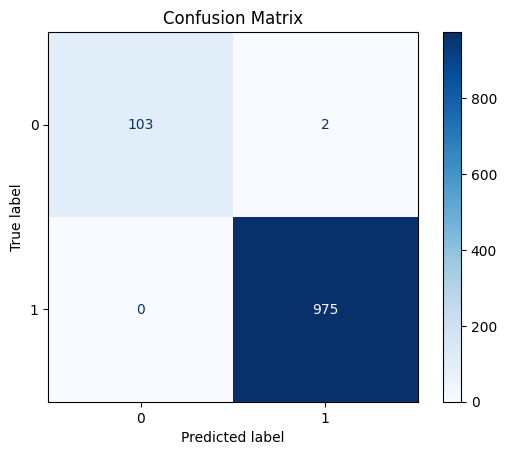

Classification Report:

              precision    recall  f1-score   support

 Non-Gunshot       1.00      0.98      0.99       105
     Gunshot       1.00      1.00      1.00       975

    accuracy                           1.00      1080
   macro avg       1.00      0.99      0.99      1080
weighted avg       1.00      1.00      1.00      1080



In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping


gunshot_data = pd.read_csv('/content/drive/MyDrive/sevenlumi_data/data_to_fed/cleaned_features.csv')
non_gunshot_data = pd.read_csv('/content/drive/MyDrive/sevenlumi_data/data_to_fed/cleaned_non_gunshot_features.csv')


drop_columns = ['Gun_Type', 'Distance', 'X', 'Y', 'Z', 'Mic', 'Arrival_Time_Difference']
gunshot_data = gunshot_data.drop(columns=drop_columns)
non_gunshot_data = non_gunshot_data.drop(columns=drop_columns)


data = pd.concat([gunshot_data, non_gunshot_data], ignore_index=True)


X = data.drop(columns=['Gunshot'])
y = data['Gunshot']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weight_dict)


input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))


attention_output = MultiHeadAttention(num_heads=4, key_dim=16)(input_layer, input_layer)
attention_output = Dropout(0.3)(attention_output)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + input_layer)


ffn = Dense(64, activation='relu')(attention_output)
ffn = Dropout(0.3)(ffn)
ffn = Dense(16, activation='relu')(ffn)  # 🔥 match back to 16 units


ffn_output = LayerNormalization(epsilon=1e-6)(ffn + attention_output)


x = GlobalAveragePooling1D()(ffn_output)


x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)


model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


y_pred_prob = model.predict(X_test_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Non-Gunshot', 'Gunshot']))


In [ ]:

model.save('/content/drive/MyDrive/sevenlumi_data/models/cst_transformer_gunshot_detector_model.h5')

print("Model saved successfully!")

Model saved successfully!
